### Reference: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=HhIgGq3za0yh

Files already downloaded and verified


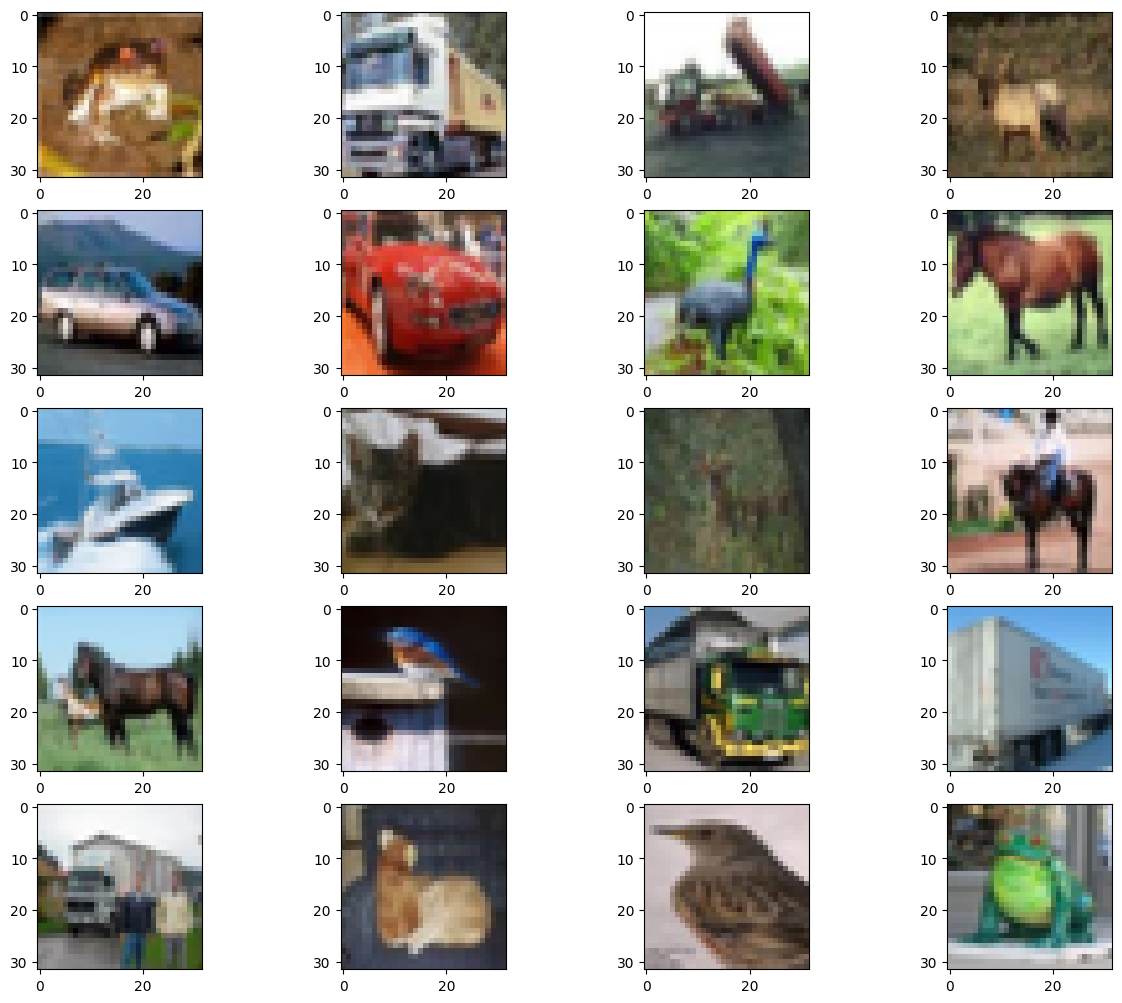

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.CIFAR10(root="./data", download=True)
show_images(data)

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    # Load the full CIFAR-10 training and test datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)
    
    # Class index for 'airplane'
    class_index = 0  # 'airplane'
    
    # Get indices of all 'airplane' images in the training dataset
    train_class_indices = [i for i, label in enumerate(train_dataset.targets) if label == class_index]
    # Get indices of all 'airplane' images in the test dataset
    test_class_indices = [i for i, label in enumerate(test_dataset.targets) if label == class_index]
    
    # Create subsets from the full datasets including only 'airplane'
    train_class_dataset = Subset(train_dataset, train_class_indices)
    test_class_dataset = Subset(test_dataset, test_class_indices)
    
    # Combine the training and test class-specific datasets
    combined_class_dataset = ConcatDataset([train_class_dataset, test_class_dataset])
    
    return combined_class_dataset
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


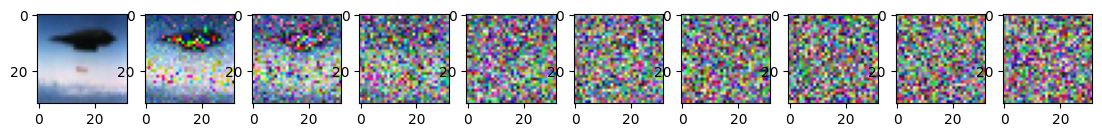

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [5]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()          

Epoch 0 | step 000 Loss: 0.1323988437652588 


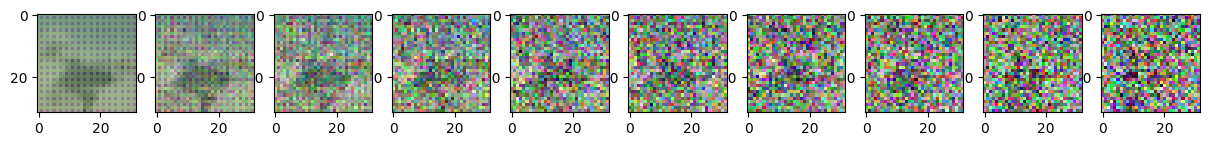

Epoch 5 | step 000 Loss: 0.13938556611537933 


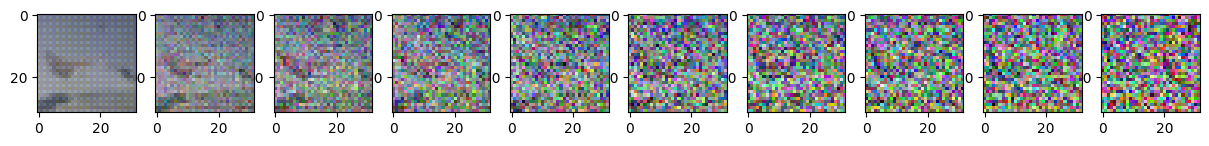

Epoch 10 | step 000 Loss: 0.12443311512470245 


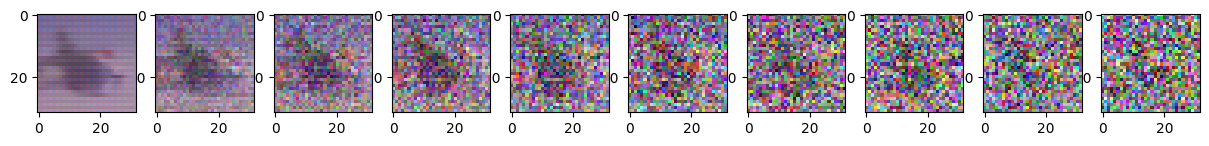

Epoch 15 | step 000 Loss: 0.125857874751091 


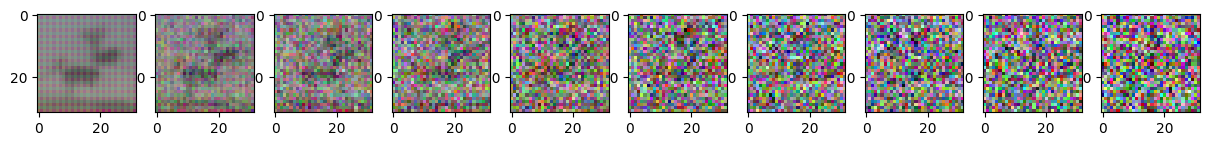

Epoch 20 | step 000 Loss: 0.1283455491065979 


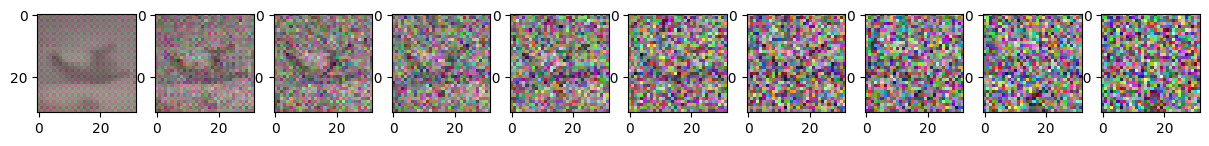

Epoch 25 | step 000 Loss: 0.13601747155189514 


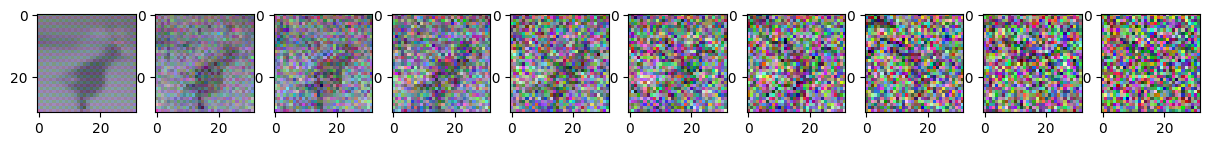

Epoch 30 | step 000 Loss: 0.1314234435558319 


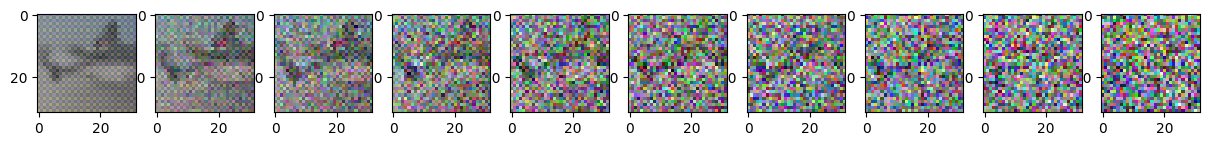

Epoch 35 | step 000 Loss: 0.12499482929706573 


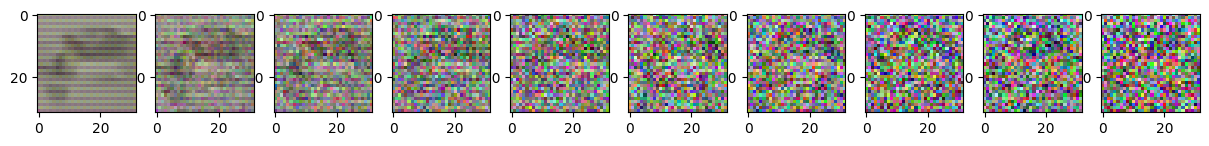

Epoch 40 | step 000 Loss: 0.12460428476333618 


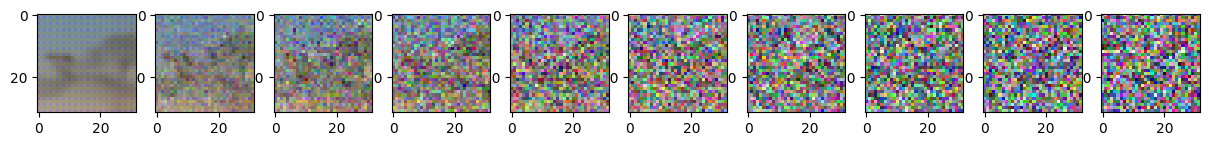

Epoch 45 | step 000 Loss: 0.129562646150589 


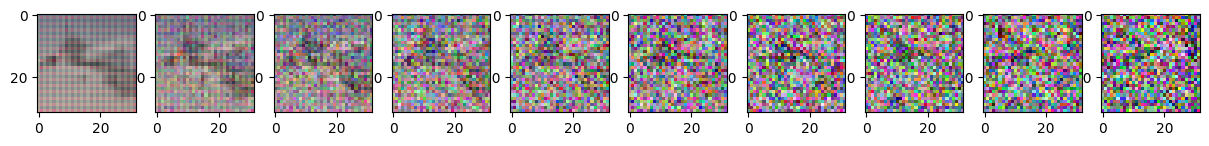

Epoch 50 | step 000 Loss: 0.13685020804405212 


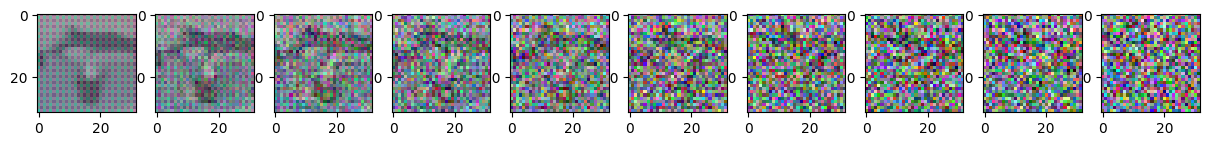

Epoch 55 | step 000 Loss: 0.12848412990570068 


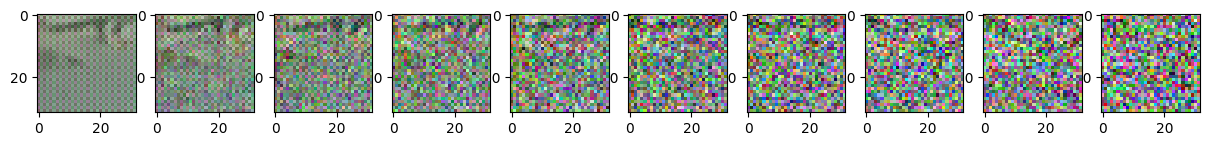

Epoch 60 | step 000 Loss: 0.14545580744743347 


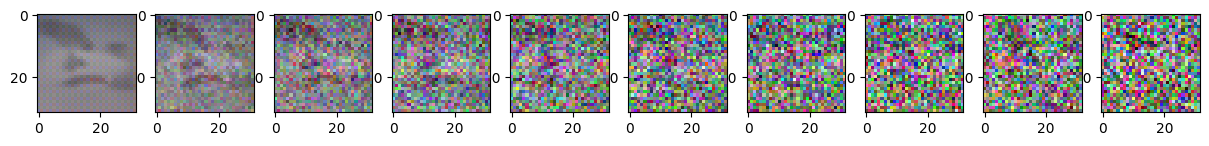

Epoch 65 | step 000 Loss: 0.11677977442741394 


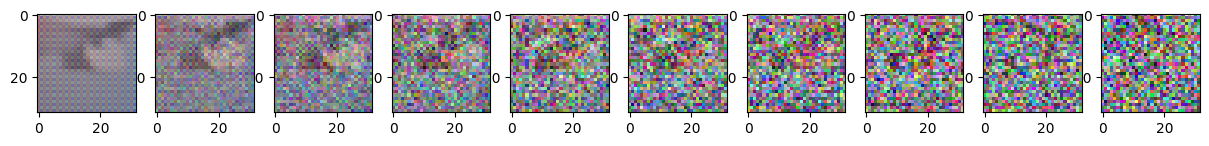

Epoch 70 | step 000 Loss: 0.13507230579853058 


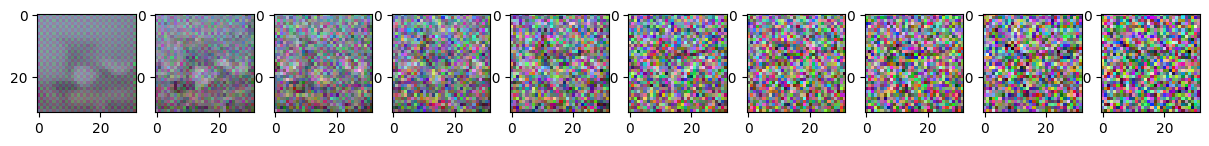

Epoch 75 | step 000 Loss: 0.12810994684696198 


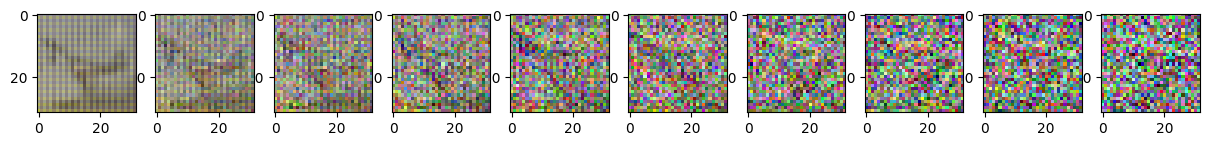

Epoch 80 | step 000 Loss: 0.13529404997825623 


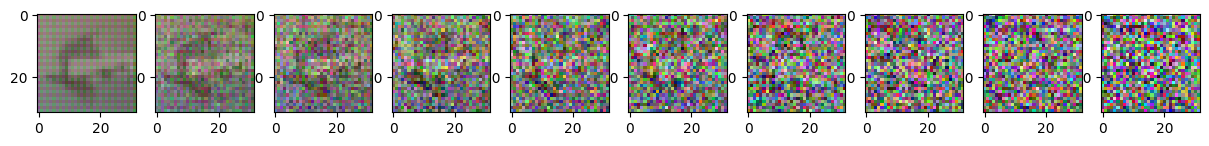

Epoch 85 | step 000 Loss: 0.1368299126625061 


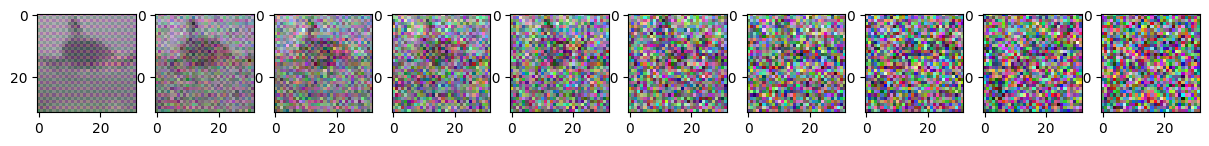

Epoch 90 | step 000 Loss: 0.12161581218242645 


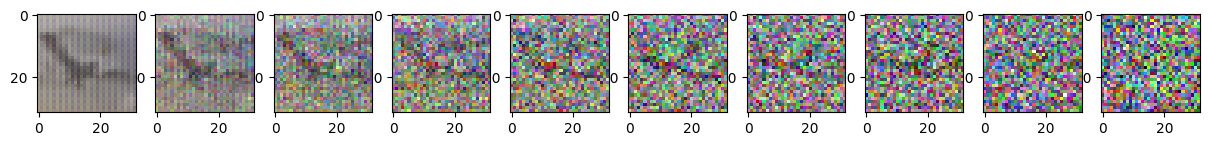

Epoch 95 | step 000 Loss: 0.12429474294185638 


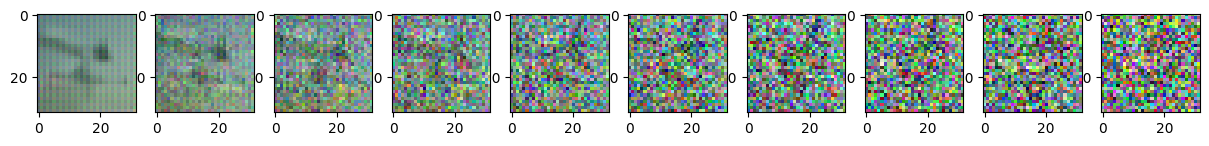

Epoch 100 | step 000 Loss: 0.13798390328884125 


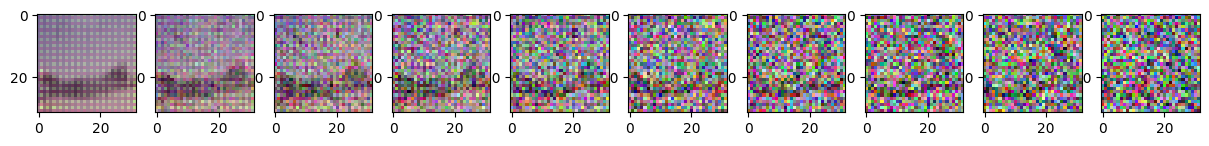

Epoch 105 | step 000 Loss: 0.12940514087677002 


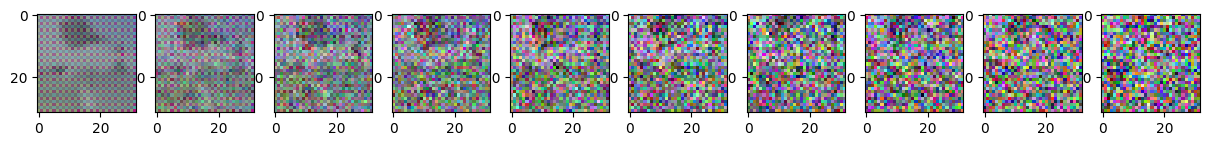

Epoch 110 | step 000 Loss: 0.1255417913198471 


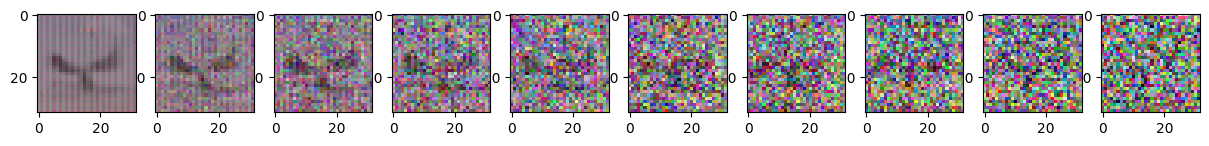

Epoch 115 | step 000 Loss: 0.1278553307056427 


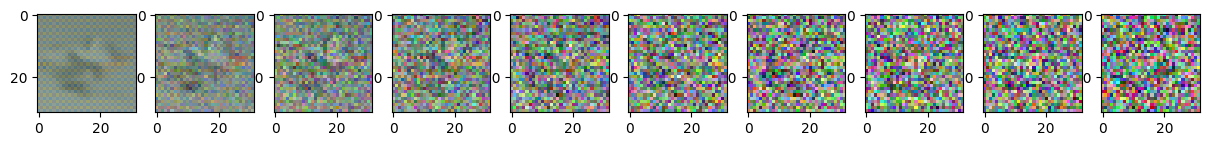

Epoch 120 | step 000 Loss: 0.133777916431427 


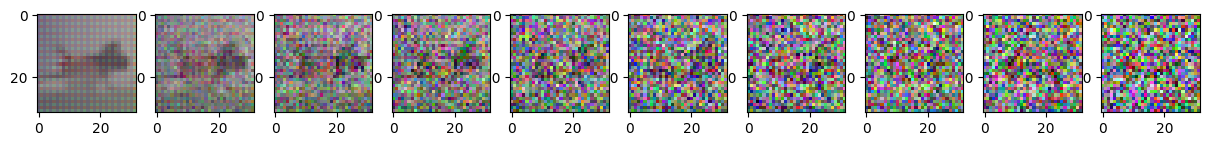

Epoch 125 | step 000 Loss: 0.12685838341712952 


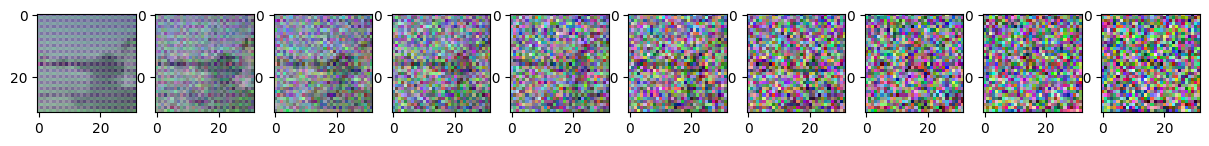

Epoch 130 | step 000 Loss: 0.13822975754737854 


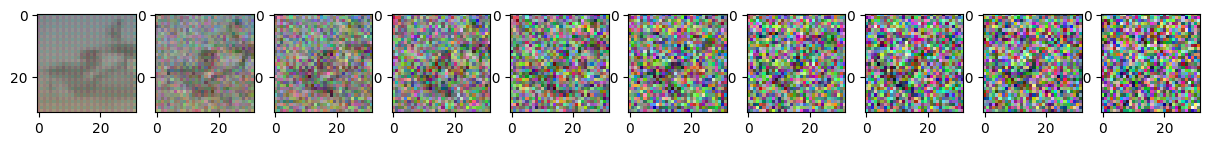

Epoch 135 | step 000 Loss: 0.11712905764579773 


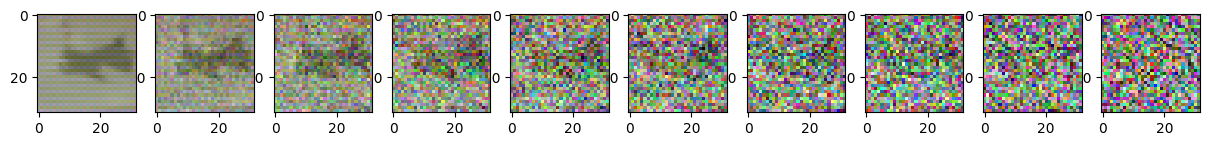

Epoch 140 | step 000 Loss: 0.13946354389190674 


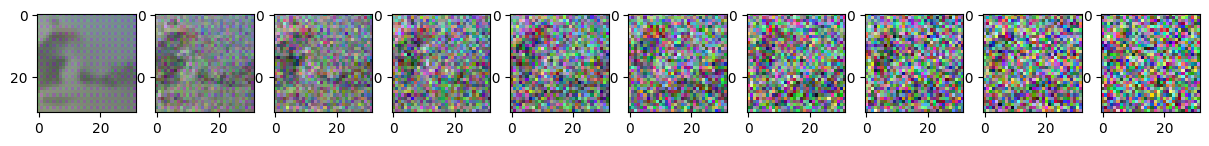

Epoch 145 | step 000 Loss: 0.13511107861995697 


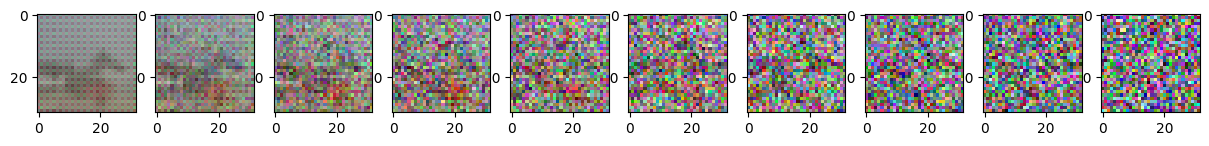

Epoch 150 | step 000 Loss: 0.12942613661289215 


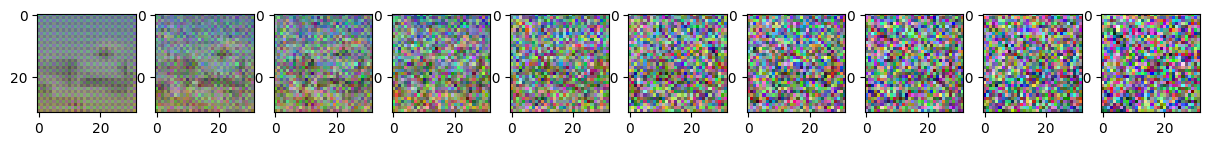

Epoch 155 | step 000 Loss: 0.1283208727836609 


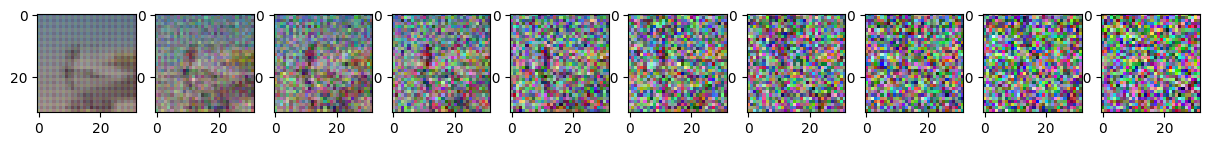

Epoch 160 | step 000 Loss: 0.13215798139572144 


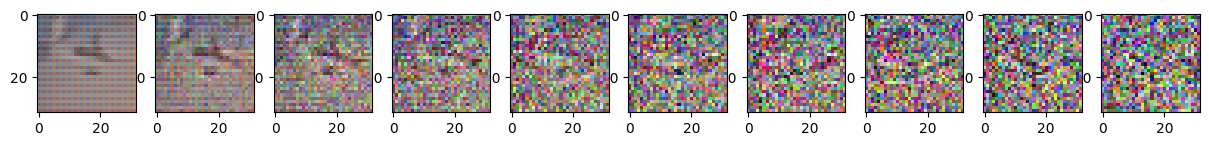

Epoch 165 | step 000 Loss: 0.14047054946422577 


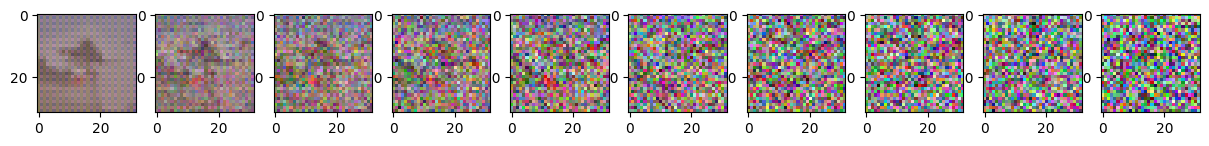

Epoch 170 | step 000 Loss: 0.1274951994419098 


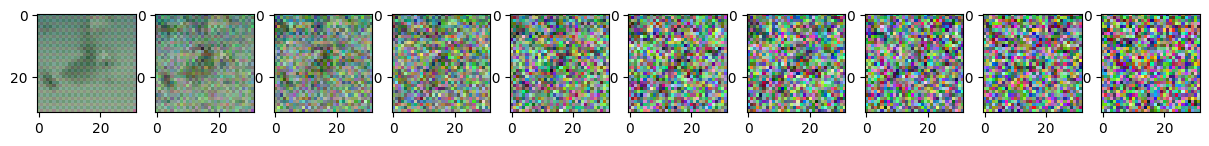

Epoch 175 | step 000 Loss: 0.13219989836215973 


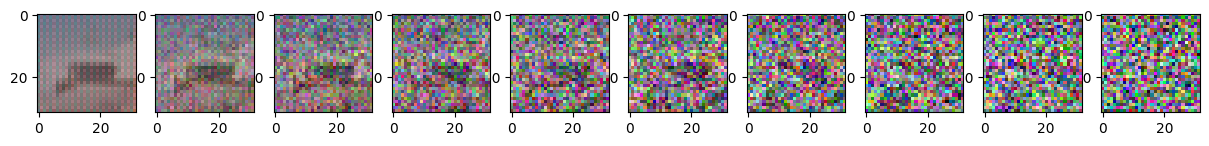

Epoch 180 | step 000 Loss: 0.13868944346904755 


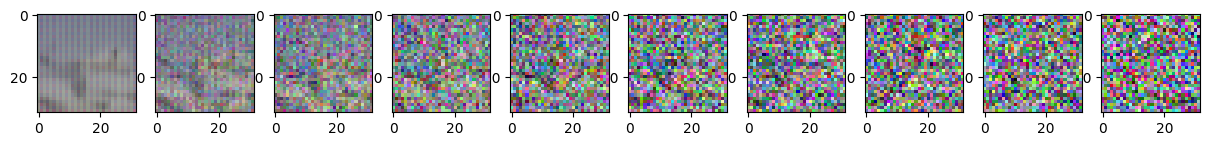

Epoch 185 | step 000 Loss: 0.12970678508281708 


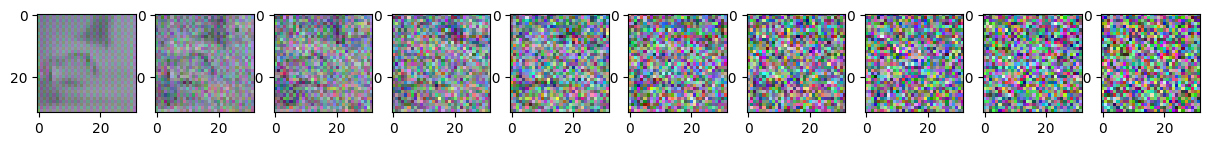

Epoch 190 | step 000 Loss: 0.13469547033309937 


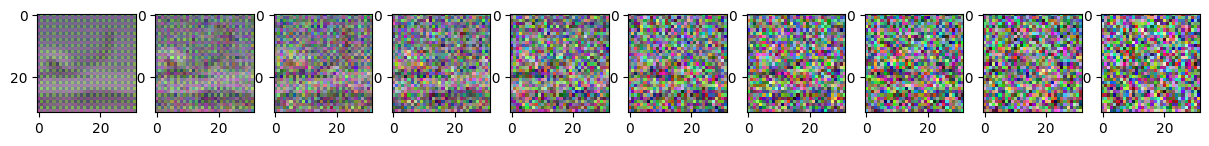

Epoch 195 | step 000 Loss: 0.12196403741836548 


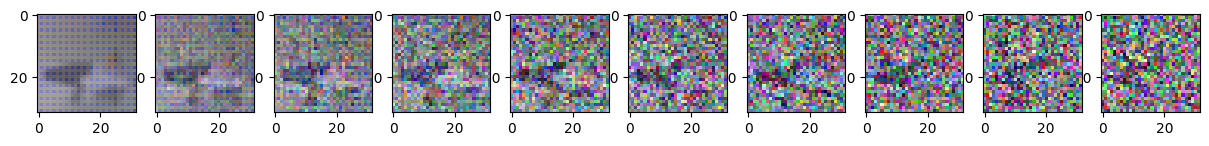

Epoch 200 | step 000 Loss: 0.13405150175094604 


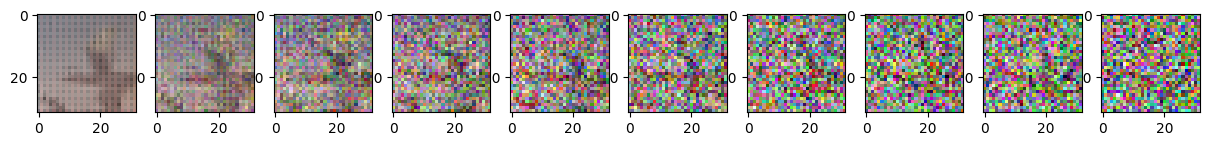

Epoch 205 | step 000 Loss: 0.1433783769607544 


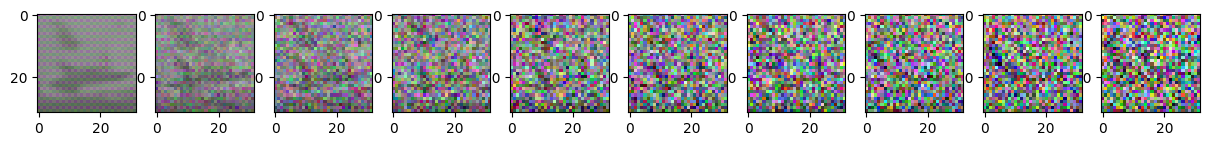

Epoch 210 | step 000 Loss: 0.12515884637832642 


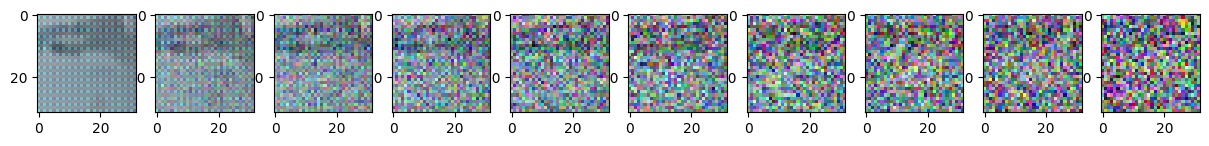

Epoch 215 | step 000 Loss: 0.13519717752933502 


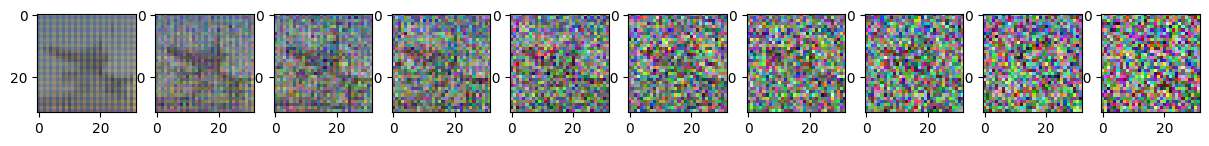

Epoch 220 | step 000 Loss: 0.12149219214916229 


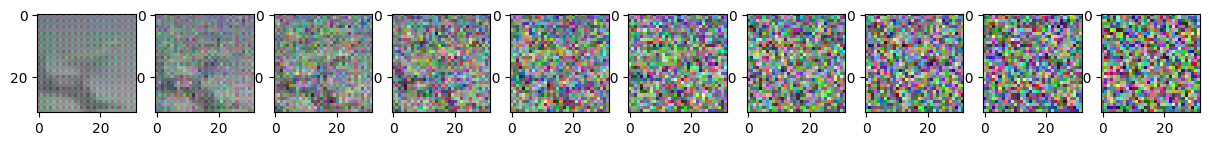

Epoch 225 | step 000 Loss: 0.1241549700498581 


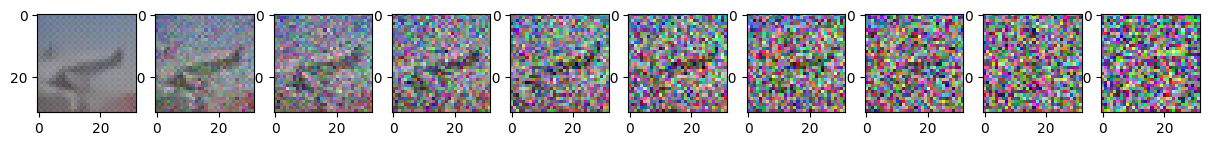

Epoch 230 | step 000 Loss: 0.12107031047344208 


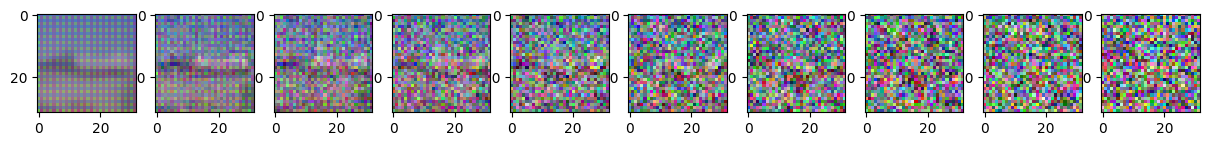

Epoch 235 | step 000 Loss: 0.1156412661075592 


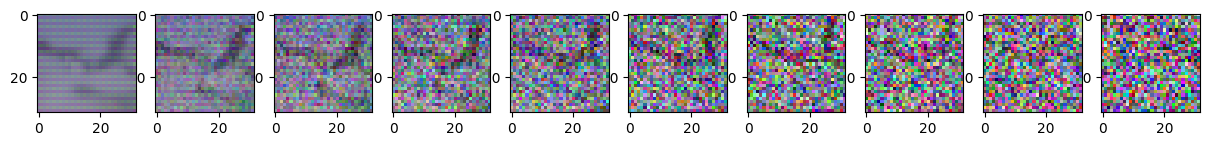

Epoch 240 | step 000 Loss: 0.13711439073085785 


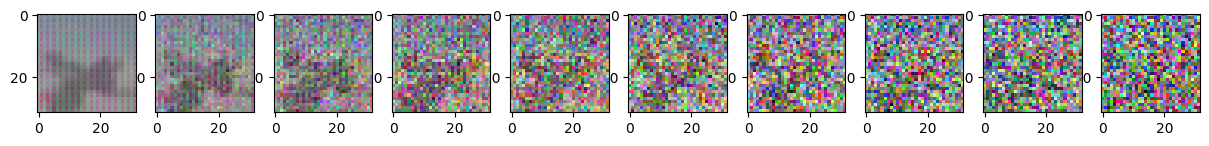

Epoch 245 | step 000 Loss: 0.12175709009170532 


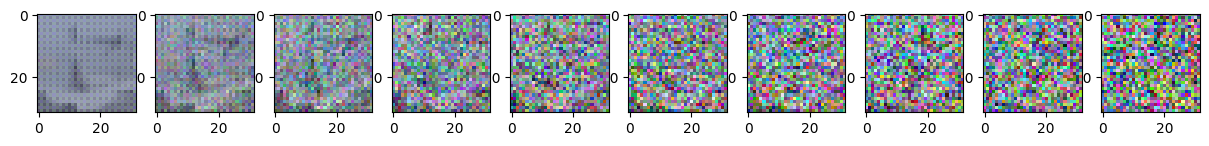

Epoch 250 | step 000 Loss: 0.12813153862953186 


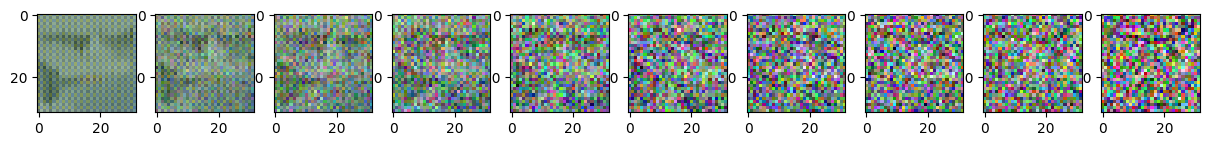

Epoch 255 | step 000 Loss: 0.13859009742736816 


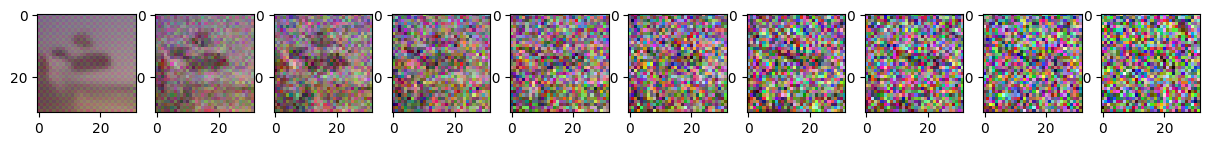

Epoch 260 | step 000 Loss: 0.1341547667980194 


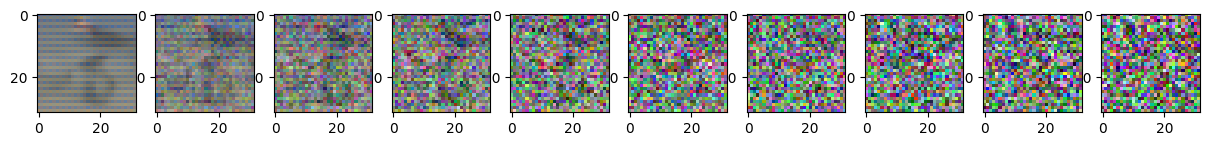

Epoch 265 | step 000 Loss: 0.14437556266784668 


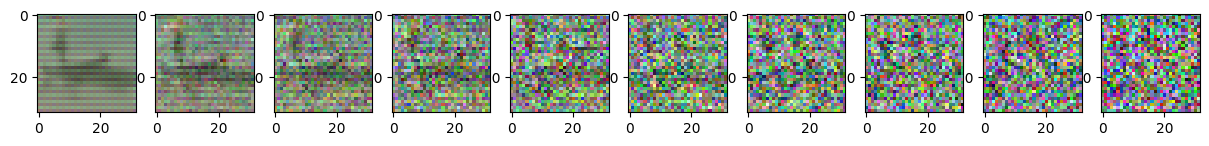

Epoch 270 | step 000 Loss: 0.12488655745983124 


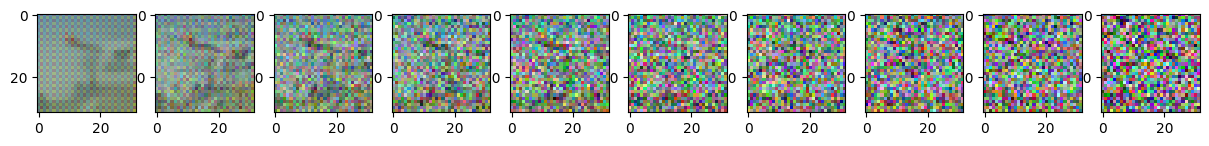

Epoch 275 | step 000 Loss: 0.1181950494647026 


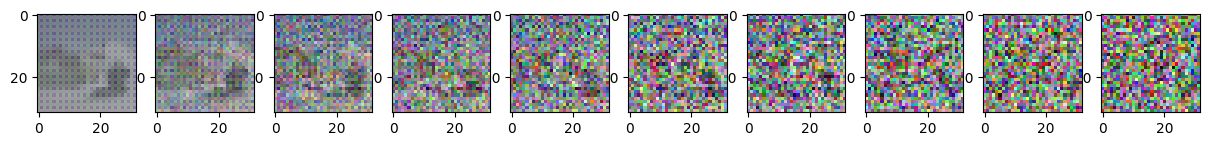

Epoch 280 | step 000 Loss: 0.1285587102174759 


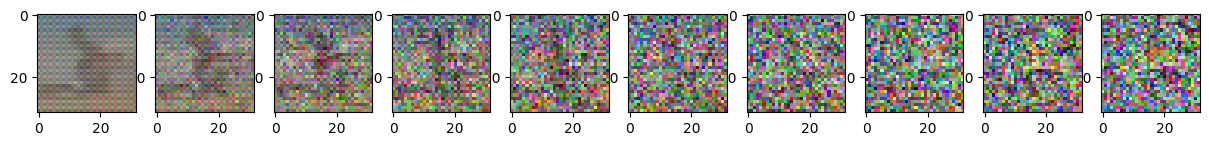

Epoch 285 | step 000 Loss: 0.1401827484369278 


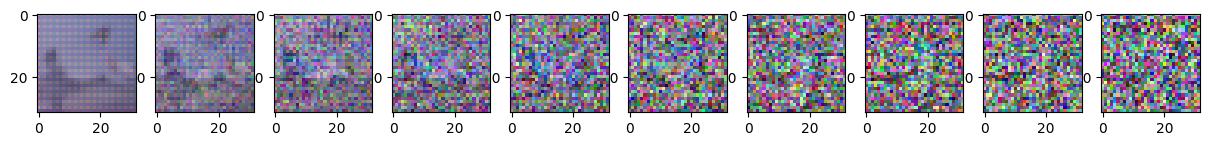

Epoch 290 | step 000 Loss: 0.11943985521793365 


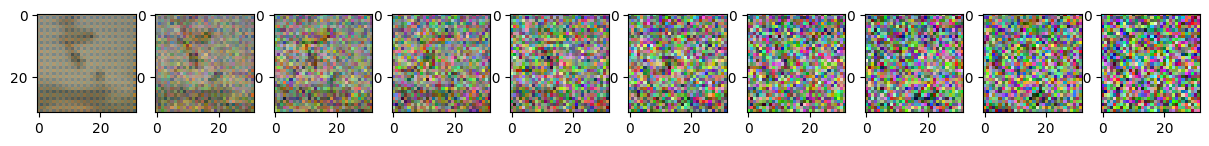

Epoch 295 | step 000 Loss: 0.12181976437568665 


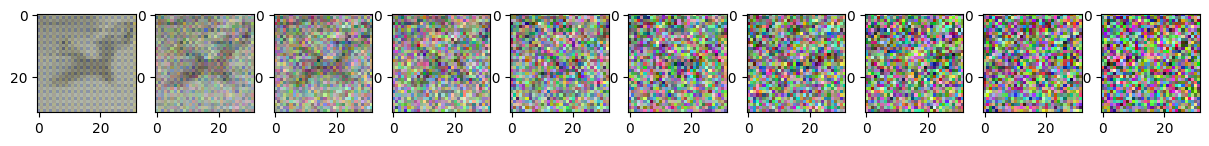

Epoch 300 | step 000 Loss: 0.13467174768447876 


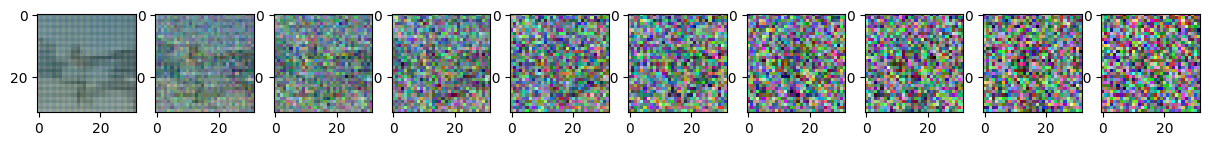

Epoch 305 | step 000 Loss: 0.12860429286956787 


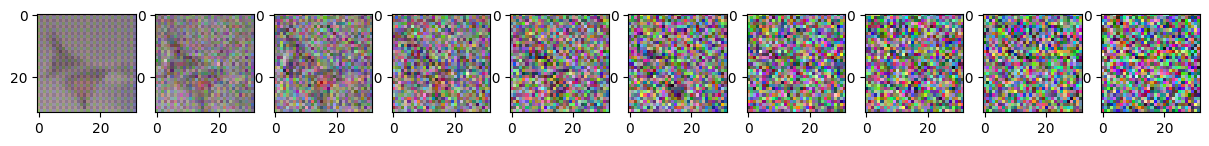

Epoch 310 | step 000 Loss: 0.12631824612617493 


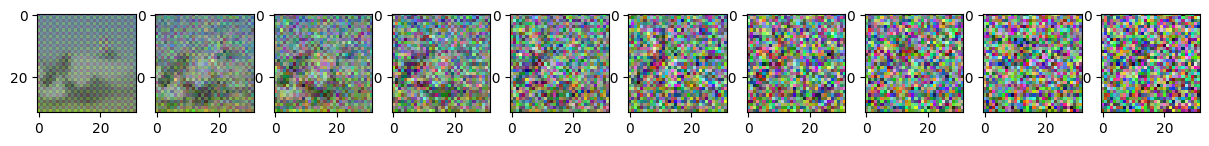

Epoch 315 | step 000 Loss: 0.11317296326160431 


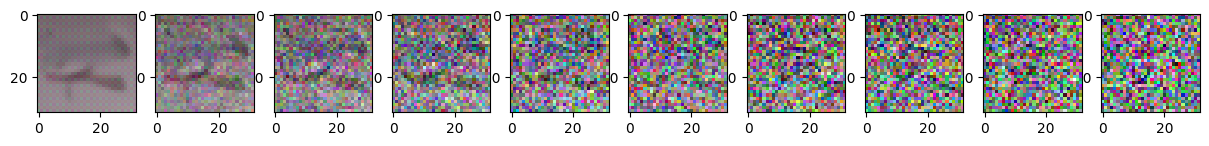

Epoch 320 | step 000 Loss: 0.14005587995052338 


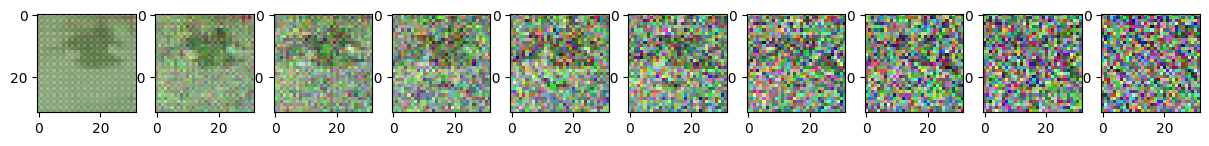

Epoch 325 | step 000 Loss: 0.13392816483974457 


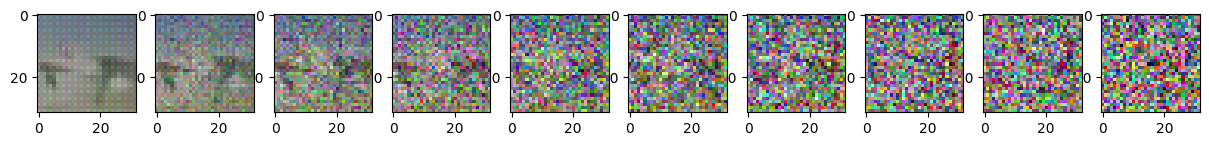

Epoch 330 | step 000 Loss: 0.11792650818824768 


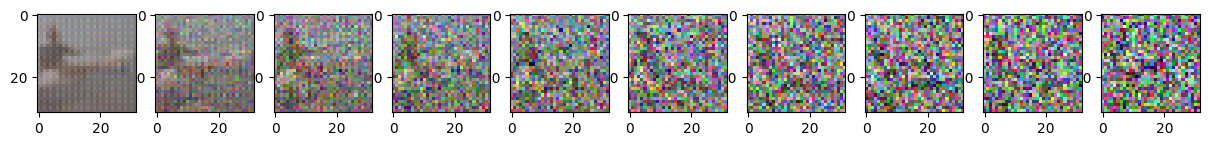

Epoch 335 | step 000 Loss: 0.13582062721252441 


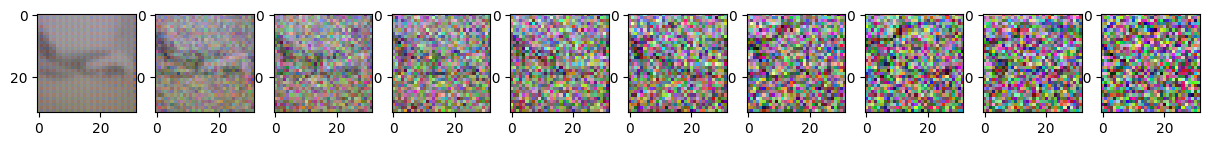

Epoch 340 | step 000 Loss: 0.13807439804077148 


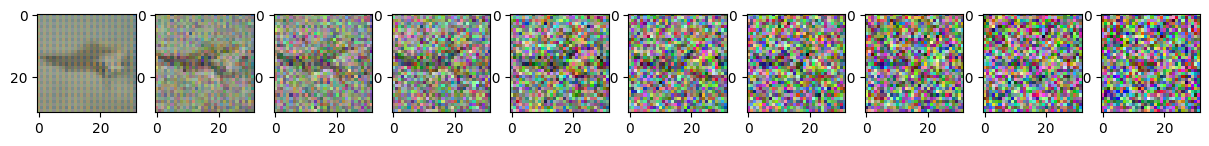

Epoch 345 | step 000 Loss: 0.14164337515830994 


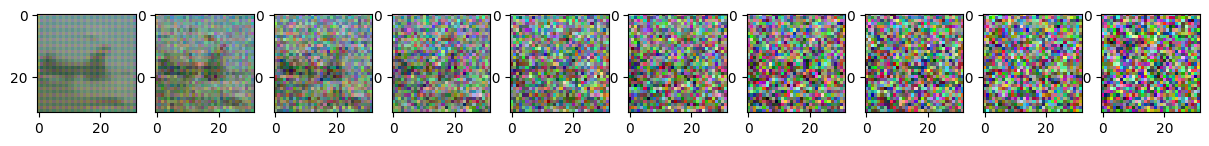

Epoch 350 | step 000 Loss: 0.12065508216619492 


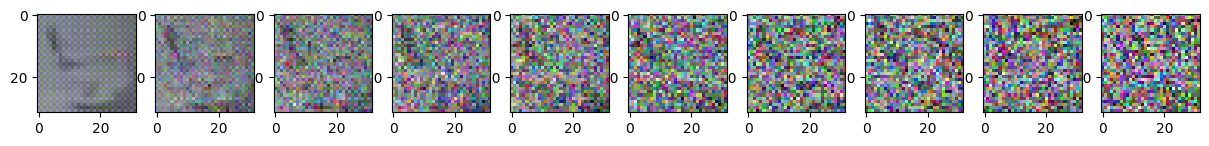

Epoch 355 | step 000 Loss: 0.12336999177932739 


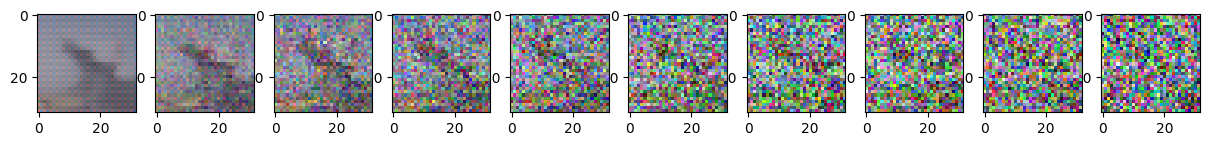

Epoch 360 | step 000 Loss: 0.14581124484539032 


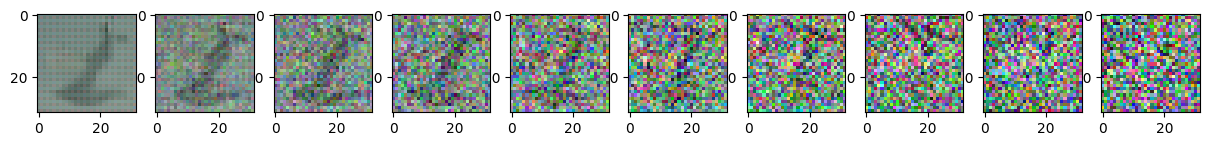

Epoch 365 | step 000 Loss: 0.1345692127943039 


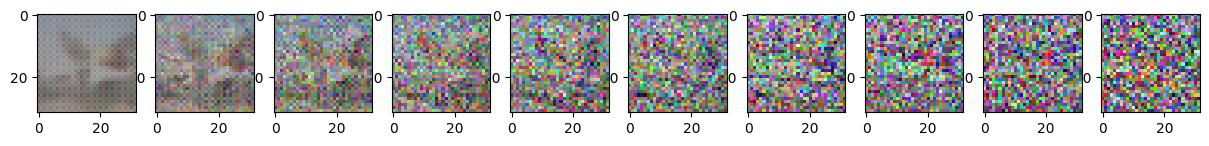

Epoch 370 | step 000 Loss: 0.1252613067626953 


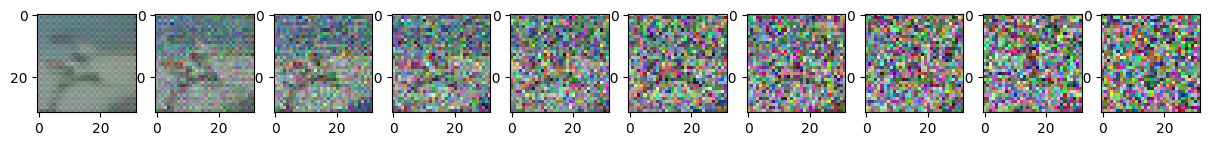

Epoch 375 | step 000 Loss: 0.13162335753440857 


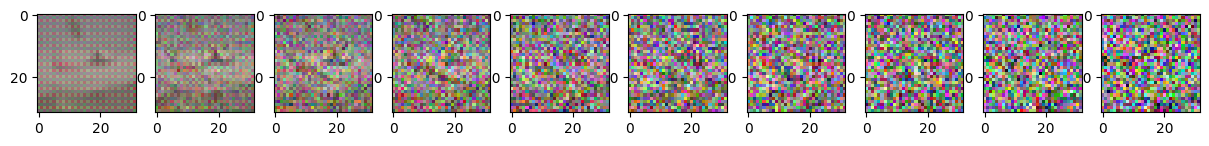

Epoch 380 | step 000 Loss: 0.12071429193019867 


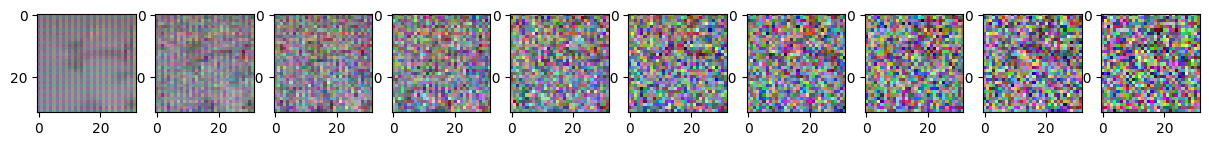

Epoch 385 | step 000 Loss: 0.1286267191171646 


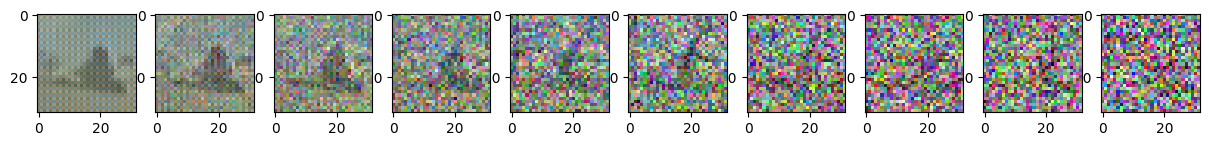

Epoch 390 | step 000 Loss: 0.11885427683591843 


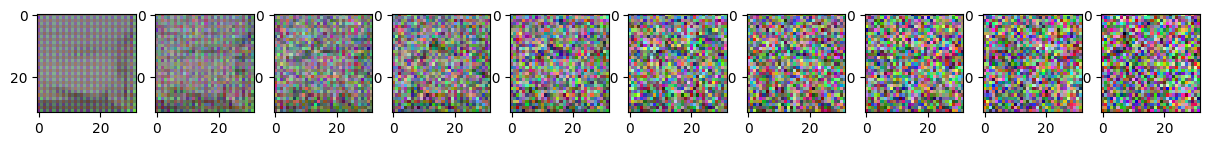

Epoch 395 | step 000 Loss: 0.11856889724731445 


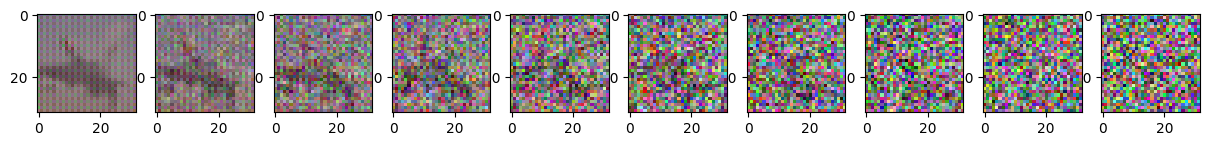

Epoch 400 | step 000 Loss: 0.12444667518138885 


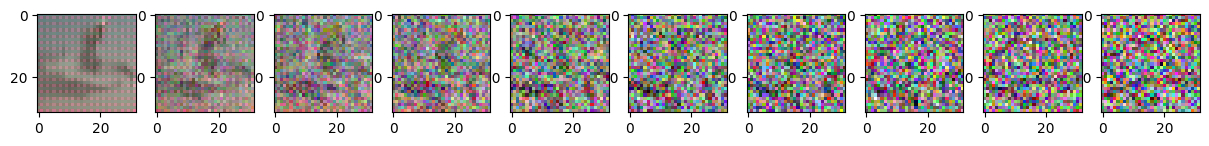

Epoch 405 | step 000 Loss: 0.12430918216705322 


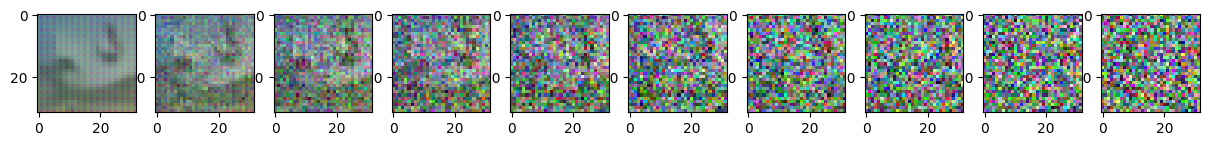

Epoch 410 | step 000 Loss: 0.127101331949234 


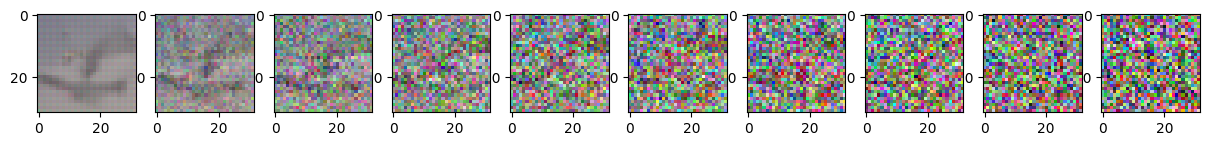

Epoch 415 | step 000 Loss: 0.128938227891922 


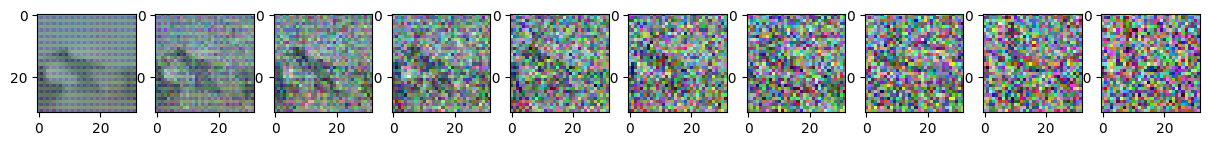

Epoch 420 | step 000 Loss: 0.11590033769607544 


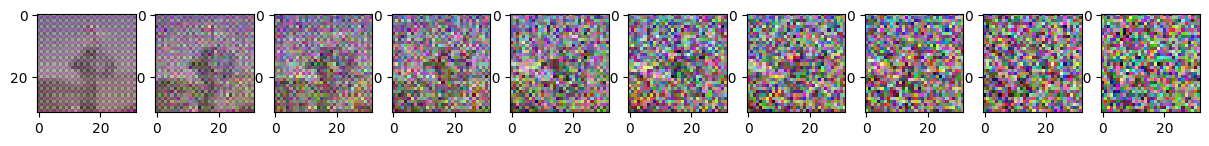

Epoch 425 | step 000 Loss: 0.13866278529167175 


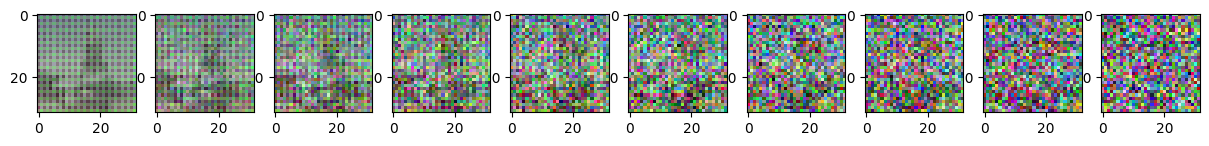

Epoch 430 | step 000 Loss: 0.11745783686637878 


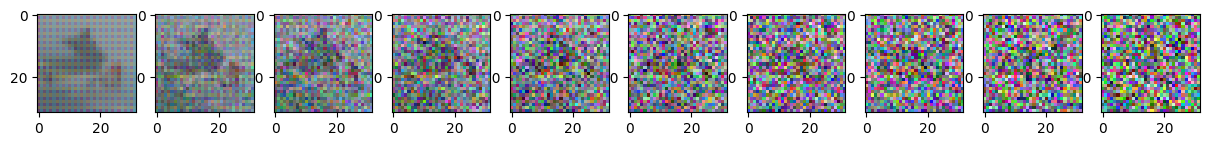

Epoch 435 | step 000 Loss: 0.12374331802129745 


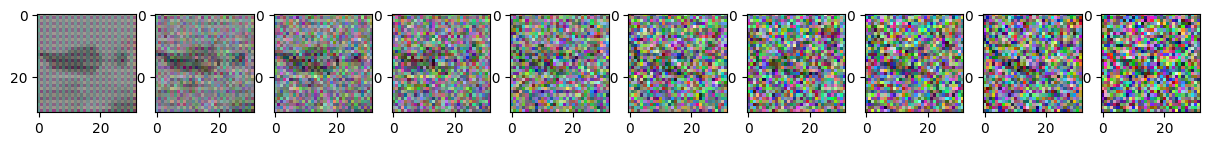

Epoch 440 | step 000 Loss: 0.1263926476240158 


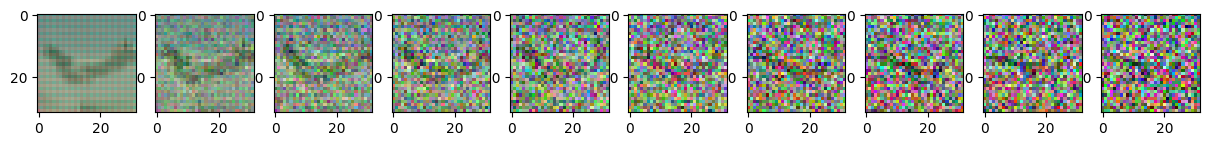

Epoch 445 | step 000 Loss: 0.1324542760848999 


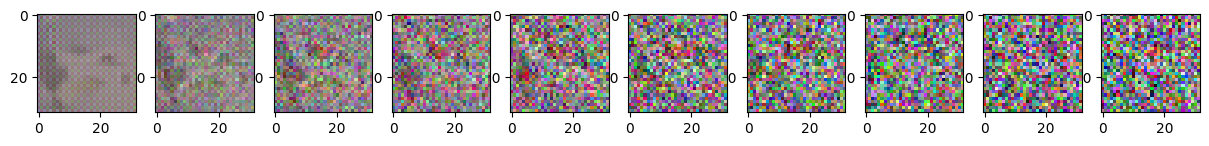

Epoch 450 | step 000 Loss: 0.13710549473762512 


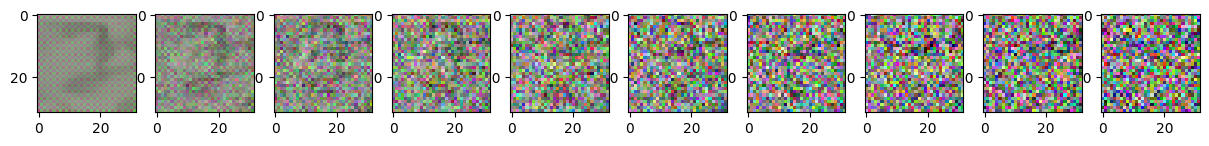

Epoch 455 | step 000 Loss: 0.13143795728683472 


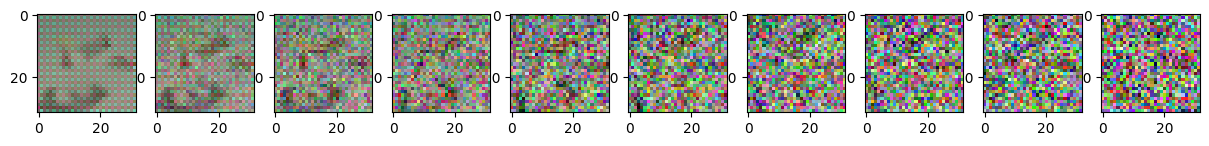

Epoch 460 | step 000 Loss: 0.13100416958332062 


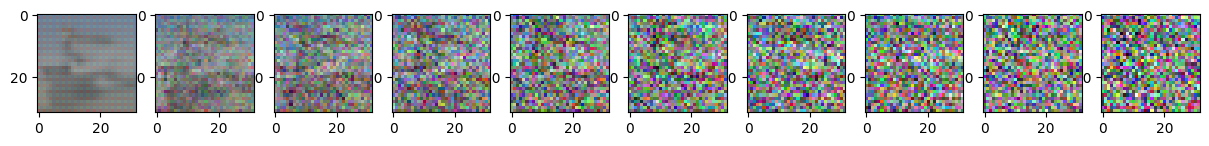

Epoch 465 | step 000 Loss: 0.12066733837127686 


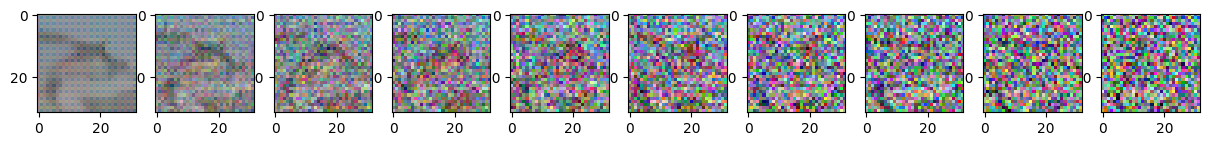

Epoch 470 | step 000 Loss: 0.11541356891393661 


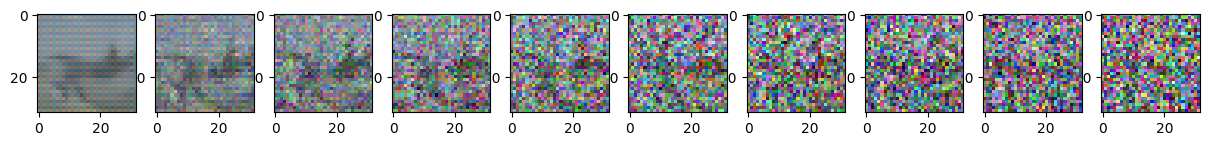

Epoch 475 | step 000 Loss: 0.1184590682387352 


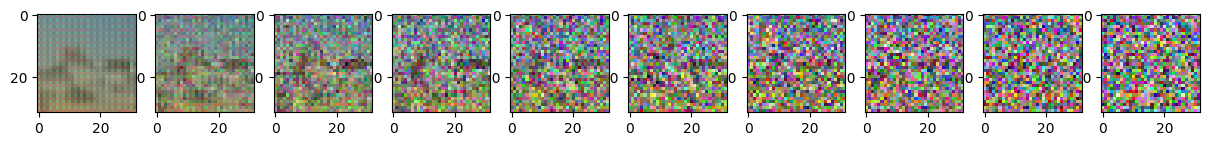

Epoch 480 | step 000 Loss: 0.12197055667638779 


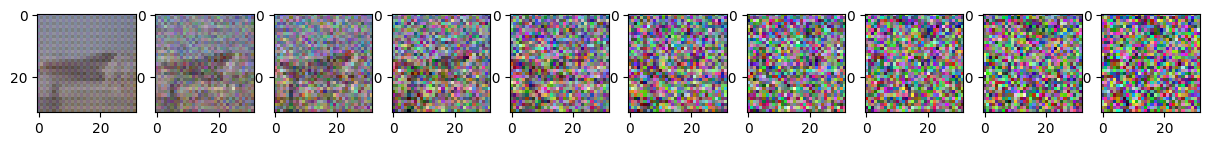

Epoch 485 | step 000 Loss: 0.11775486171245575 


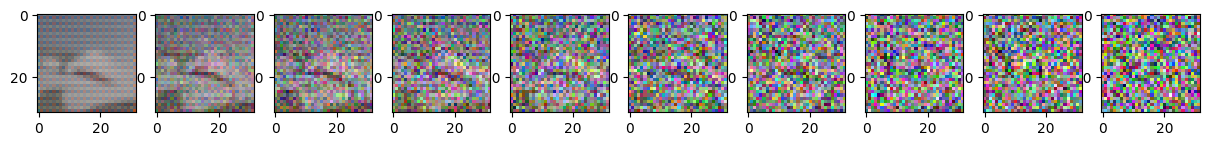

Epoch 490 | step 000 Loss: 0.12404843419790268 


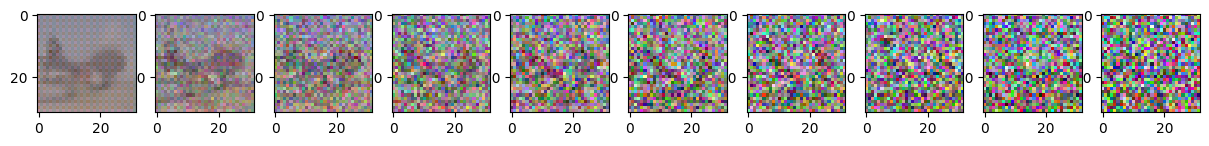

Epoch 495 | step 000 Loss: 0.12838321924209595 


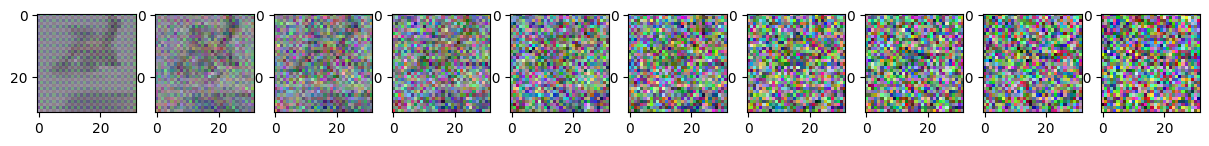

In [9]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()